<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-20 04:04:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-04-20 04:04:20 (12.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
train_df = pd.read_csv('loan_train.csv')
print(f"Shape: {train_df.shape}")
train_df.head()

Shape: (346, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Convert to date time object 

In [5]:
train_df["education"].replace({"Bechalor": "Bachelor", "college": "College"}, inplace=True)
train_df['due_date'] = pd.to_datetime(train_df['due_date'])
train_df['effective_date'] = pd.to_datetime(train_df['effective_date'])
train_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
train_df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

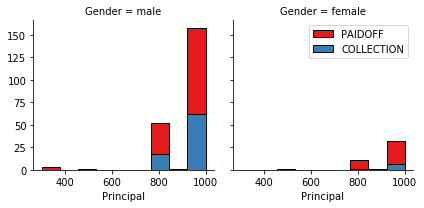

In [8]:
import seaborn as sns

bins = np.linspace(train_df.Principal.min(), train_df.Principal.max(), 10)
g = sns.FacetGrid(train_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

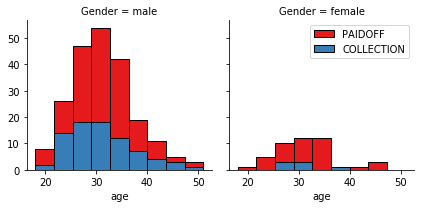

In [9]:
bins = np.linspace(train_df.age.min(), train_df.age.max(), 10)
g = sns.FacetGrid(train_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

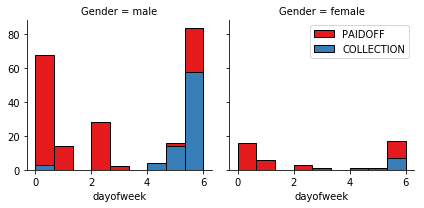

In [10]:
train_df['dayofweek'] = train_df['effective_date'].dt.dayofweek
bins = np.linspace(train_df.dayofweek.min(), train_df.dayofweek.max(), 10)
g = sns.FacetGrid(train_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
train_df['Weekend'] = train_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

## Convert Categorical features to numerical values

In [12]:
df = train_df.copy()
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,male,4,1


Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert female to 0 and male to 1:


In [14]:
# Convert female to 0 and male to 1 with LabelEncoder
le_genre = preprocessing.LabelEncoder()
le_genre.fit(['female','male'])
df['Gender'] = le_genre.transform(df['Gender'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,1,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,0,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,1,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,0,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,1,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
College               PAIDOFF        0.765101
                      COLLECTION     0.234899
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
Name: loan_status, dtype: float64

In [16]:
# Feature befor One Hot Encoding
Feature = df[['Principal','terms','age','Gender','Weekend']]

# Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
# Keep the "Master or Above" to get a better accuracy
Feature.head()

,Principal,terms,age,Gender,Weekend,Bachelor,College,High School or Below,Master or Above
0,1000,30,45,1,0,0,0,1,0
1,1000,30,33,0,0,1,0,0,0
2,1000,15,27,1,0,0,1,0,0
3,1000,30,28,0,1,0,1,0,0
4,1000,30,29,1,1,0,1,0,0


Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,Weekend,Bachelor,College,High School or Below,Master or Above
0,1000,30,45,1,0,0,0,1,0
1,1000,30,33,0,0,1,0,0,0
2,1000,15,27,1,0,0,1,0,0
3,1000,30,28,0,1,0,1,0,0
4,1000,30,29,1,1,0,1,0,0


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555,  0.42056004, -1.20577805,
        -0.38170062, -0.86968108,  1.13639374, -0.07624929],
       [ 0.51578458,  0.92071769,  0.34170148, -2.37778177, -1.20577805,
         2.61985426, -0.86968108, -0.87997669, -0.07624929],
       [ 0.51578458, -0.95911111, -0.65321055,  0.42056004, -1.20577805,
        -0.38170062,  1.14984679, -0.87997669, -0.07624929],
       [ 0.51578458,  0.92071769, -0.48739188, -2.37778177,  0.82934003,
        -0.38170062,  1.14984679, -0.87997669, -0.07624929],
       [ 0.51578458,  0.92071769, -0.3215732 ,  0.42056004,  0.82934003,
        -0.38170062,  1.14984679, -0.87997669, -0.07624929]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Train Test Split

In [20]:
# We split the dataset into training and testing sets using sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


### Classification

In [21]:
# Classifier implementing the k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# We calculate the arruracy for different value of k
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.58571429, 0.72857143, 0.7       , 0.77142857,
       0.71428571, 0.8       , 0.75714286, 0.74285714])

#### Plot model accuracy for Different number of Neighbors

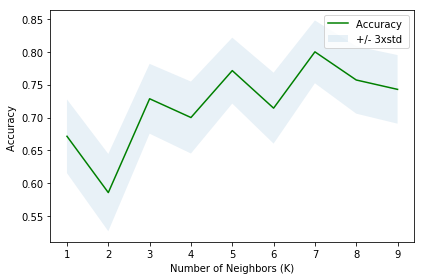

In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8 with k= 7


### Training

In [24]:
# Building the model again, using k=7
k = 7
# Train Model 
neigh_model = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [25]:
yhat = neigh_model.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Decision Tree

## Modeling

In [24]:
# import the DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [25]:
# Inside of the classifier, we specify criterion="entropy" so we can see the information gain of each node.
tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [26]:
# We fit the data with the training feature matrix X_train and training response vector y_train
tree_model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Prediction

In [27]:
# We make some predictions on the testing dataset and store it into a variable called predLoan.
yhat = tree_model.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Support Vector Machine

## Modeling (SVM with Scikit-learn)

In [28]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [29]:
yhat = SVM_model.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(C=1, solver= 'liblinear').fit(X_train,y_train)
LR_model

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
yhat = LR_model.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Model Evaluation using Test set

In [29]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [30]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-20 04:06:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-20 04:06:30 (314 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.shape

(54, 10)

In [32]:
test_df["education"].replace({"Bechalor": "Bachelor", "college": "College"}, inplace=True)
le_genre = preprocessing.LabelEncoder()
le_genre.fit(['female','male'])
test_df['Gender'] = le_genre.transform(test_df['Gender'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
test_df['Weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
feature_test = test_df[['Principal','terms','age','Gender','Weekend']]
feature_test = pd.concat([feature_test,pd.get_dummies(test_df['education'])], axis=1)
test_X = preprocessing.StandardScaler().fit(feature_test).transform(feature_test)
test_X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


array([[ 0.49362588,  0.92844966,  3.05981865, -1.97714211, -1.30384048,
         2.39791576, -0.86135677, -0.79772404, -0.19611614],
       [-3.56269116, -1.70427745,  0.53336288,  0.50578054,  0.76696499,
        -0.41702883, -0.86135677, -0.79772404,  5.09901951],
       [ 0.49362588,  0.92844966,  1.88080596, -1.97714211,  0.76696499,
        -0.41702883, -0.86135677,  1.25356634, -0.19611614],
       [ 0.49362588,  0.92844966, -0.98251057,  0.50578054,  0.76696499,
        -0.41702883,  1.16095912, -0.79772404, -0.19611614],
       [-0.66532184, -0.78854628, -0.47721942,  0.50578054,  0.76696499,
         2.39791576, -0.86135677, -0.79772404, -0.19611614]])

In [33]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### kNN

In [36]:
yhat_kNN=neigh_model.predict(test_X)
f1_kNN = f1_score(test_y, yhat_kNN, average='weighted')
jaccard_kNN = jaccard_similarity_score(test_y, yhat_kNN)
print(f"KNN F1-score: {f1_kNN:.2f}")
print(f"KNN jaccard: {jaccard_kNN:.2f}")

KNN F1-score: 0.65
KNN jaccard: 0.69


### Decison Tree

In [37]:
yhat_tree = tree_model.predict(test_X)
f1_tree = f1_score(test_y, yhat_tree, average='weighted')
jaccard_tree = jaccard_similarity_score(test_y, yhat_tree)
print(f"DT F1-score: {f1_tree:.2f}")
print(f"DT jaccard: {jaccard_tree:.2f}")

DT F1-score: 0.74
DT jaccard: 0.72


### SVM

In [38]:
yhat_svm = SVM_model.predict(test_X)
f1_svm = f1_score(test_y, yhat_svm, average='weighted')
jaccard_svm = jaccard_similarity_score(test_y, yhat_svm)
print(f"SVM F1-score: {f1_svm:.2f}")
print(f"SVM jaccard: {jaccard_svm:.2f}")

SVM F1-score: 0.76
SVM jaccard: 0.80


### Logistic Regression

In [39]:
yhat_LR = LR_model.predict(test_X)
yhat_prob = LR_model.predict_proba(test_X)

f1_LR = f1_score(test_y, yhat_LR, average='weighted')
jaccard_LR = jaccard_similarity_score(test_y, yhat_LR)
LogLoss = log_loss(test_y, yhat_prob)

print(f"LR F1-score: {f1_LR:.2f}")
print(f"LR jaccard: {jaccard_LR:.2f}")
print(f"LogLoss: {LogLoss:.2f}")

LR F1-score: 0.70
LR jaccard: 0.76
LogLoss: 0.47


# Report


In [40]:
# initialise data of lists. 
data_report = {'Algorithm':['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 
        'Jaccard':[jaccard_kNN, jaccard_tree, jaccard_svm, jaccard_LR], 
        'F1-score':[f1_kNN, f1_tree, f1_svm, f1_LR], 
        'LogLoss':[np.nan, np.nan, np.nan, LogLoss]} 
  
# Creates pandas DataFrame. 
df_report = pd.DataFrame(data=data_report, index=None) 
df_report.set_index('Algorithm',inplace=True)
df_report.round(2)

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.69,0.65,NaN
Decision Tree,0.72,0.74,NaN
SVM,0.80,0.76,NaN
LogisticRegression,0.76,0.70,0.47
